<img src="https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/notebook_banner.png" width="1024" style="float:center">
<div style="margin-top:10px; display:flex; align-items:center;">
    <div style="float:left; margin-right:10px;vertical-align:middle">
        <a href="https://www.linkedin.com/in/bruno-angles/" targer="_blank">
            <img src="https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/lkin-logo.png"/>
        </a>
    </div>
    <div> 
        Bruno Anglés (01/02/2023)
    </div>
 </div>

 # Evaluación del estado de salud de un bebé durante el parto

En el siguiente proyecto analizo los datos recogidos de un Cardiotocógrafo fetal (CGT) para predecir la salud de un bebé antes de nacer.

La cardiotocografía registra simultáneamente la frecuencia cardíaca fetal, los movimientos fetales y las contracciones uterinas. El registro permite al profesional sanitario valorar el latido cardíaco fetal durante la última etapa de la gestación y la respuesta del bebé a las contracciones durante todo el parto hasta el nacimiento.

En este sentido, se recogieron datos de 2.126 cardiotocogramas fetales (CTG) y se midieron las características de diagnóstico respectivas. Los CTG también fueron clasificados por tres obstetras expertos y se asignó una etiqueta de clasificación de consenso a cada uno de ellos. De esta manera las características de diagnóstico representan el conjunto de variables explicativas que va a permitir estimar el estado fetal (target) en normal o anormal.

## Objetivo

Entrenar un algoritmo (Machine Learning) capaz de predecir el estado de salud del feto a partir de los datos recogidos por el CTG.

El problema que se plantea es de *Aprendizaje Supervisado* y se restringe los posibles algoritmos a estas dos famílias

- SVM - Support Vector Machine
- NB - Naive Bayes

## Metodología

1. Carga de datos y comprobar si los datos son completos o hay *valores missing*. Los datos se proporcionan a través del archivo CSV [ASI_casoPractico.csv](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/ASI_casoPractico.csv)
1. Análisis exploratiorio de los datos. En el cuál he analizado las variables explicativas y su correlación con la variable a prededir, con el objetivo de entender bien su significado y tener una intuición sobre cómo preparar los datos de la forma más optima para cada uno de los algoritmos que vamos a probar.
1. Entrenamiento de Naive Bayes. Este paso incluye un preprocesado de los datos de modo que podamos obtener el mejor resultado. Para ello me he apoyado de unos [cuadernos auxiliares](https://github.com/tuxsy/iebs-master-data-science/tree/main/m04/proyecto/Pruebas) en los que he ido probando distintas opciones.
1. Entrenamiento de Support Vector Machine. Este paso incluye un preprocesado de los datos de modo que podamos obtener el mejor resultado. Para ello me he apoyado de unos [cuadernos auxiliares](https://github.com/tuxsy/iebs-master-data-science/tree/main/m04/proyecto/Pruebas) en los que he ido probando distintas opciones.
1. Comparativa entre los modelos. Para valida los modelos vamos a emplear las cuervas ROC y usaremos como métrica el área bajo la curva (AUC)
1. Determinar el mejor umbral para la pedicción.


## Conclusiones

Al final he conseguido entrenar un modelo SVM con:

- **AUC sobre el conjunto de entrenamiento: 0.99**
- **AUC sobre el conjunto de test: 0.98**

Mediante el algoritmo Naive Bayes he conseguido resultados buenos pero no tanto. El mejor modelo tiene estas características

- AUC sobre el conjunto de entrenamiento: 0.96
- AUC sobre el conjunto de test: 0.96

A pesar de que el model Naive Bayes no ha conseguido llegar al 0.99 de SVM tiene un rendimiento muy bueno y con menos sobreajuste. Con lo cual podríamos elegir cualquiera de los dos.

In [1]:
# IMPORTACION DE LIBRERIAS
import numpy as np
import pandas as pd

# LIBRERIAS PARA HACER GRAFICOS
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as xp
from matplotlib import style
from mlxtend.plotting import plot_decision_regions

# PREPROCESADO, MODELADO y VALLIDACIÓN 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


# IGNORAMOS LOS WARNING
import warnings
warnings.filterwarnings('ignore')

# ESTILO DE LOS GRÁFICOS
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['axes.titlesize'] = "10"
style.use('ggplot') or plt.style.use('ggplot')

plt_colors = list(sns.color_palette().as_hex())

def plt_color(i):
    return plt_colors[i % len(plt_colors)]


## Carga del fichero de datos

In [2]:
! [ -f ASI_casoPractico.csv ] || wget https://raw.githubusercontent.com/tuxsy/iebs-master-data-science/main/m04/c2/sprint/ASI_casoPractico.csv

data = pd.read_csv("ASI_casoPractico.csv", sep=";")

data.head()

,ID,b,e,LBE,AC,FM,UC,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,Target
0,1,240,357,120,0,0,0,73,0.5,43,...,62,126,2,0,120,137,121,73,1,1
1,2,5,632,132,4,0,4,17,2.1,0,...,68,198,6,1,141,136,140,12,0,0
2,3,177,779,133,2,0,5,16,2.1,0,...,68,198,5,1,141,135,138,13,0,0
3,4,411,1192,134,2,0,6,16,2.4,0,...,53,170,11,0,137,134,137,13,1,0
4,5,533,1147,132,4,0,5,16,2.4,0,...,53,170,9,0,137,136,138,11,1,0


## Análisis exploratorio

### Información del conjunto de datos

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        2126 non-null   int64  
 1   b         2126 non-null   int64  
 2   e         2126 non-null   int64  
 3   LBE       2126 non-null   int64  
 4   AC        2126 non-null   int64  
 5   FM        2126 non-null   int64  
 6   UC        2126 non-null   int64  
 7   ASTV      2126 non-null   int64  
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   int64  
 10  MLTV      2126 non-null   float64
 11  DL        2126 non-null   int64  
 12  DS        2126 non-null   int64  
 13  DP        2126 non-null   int64  
 14  DR        2126 non-null   int64  
 15  Width     2126 non-null   int64  
 16  Min       2126 non-null   int64  
 17  Max       2126 non-null   int64  
 18  Nmax      2126 non-null   int64  
 19  Nzeros    2126 non-null   int64  
 20  Mode      2126 non-null   int6

### Valores únicos

In [4]:
data.agg(["nunique"]).T

,nunique
ID,2126
b,979
e,1064
LBE,48
AC,22
FM,96
UC,19
ASTV,75
MSTV,57
ALTV,87


### Eliminar columnas innecesarias

In [5]:
data = data.drop(["ID","b","e","DR"], axis = 1)
data.head()

,LBE,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,DS,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,Target
0,120,0,0,0,73,0.5,43,2.4,0,0,...,62,126,2,0,120,137,121,73,1,1
1,132,4,0,4,17,2.1,0,10.4,2,0,...,68,198,6,1,141,136,140,12,0,0
2,133,2,0,5,16,2.1,0,13.4,2,0,...,68,198,5,1,141,135,138,13,0,0
3,134,2,0,6,16,2.4,0,23.0,2,0,...,53,170,11,0,137,134,137,13,1,0
4,132,4,0,5,16,2.4,0,19.9,0,0,...,53,170,9,0,137,136,138,11,1,0


### Valores missing - nulos

In [6]:
data.isnull().sum()

LBE         0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
Target      0
dtype: int64

### Clasificación de variables

In [7]:
# Tipos de variables contenidos en el dataset
list(data.dtypes.unique())

[dtype('int64'), dtype('float64')]

Todas las varaibles del daset son numéricas y cuantitativas, se clasificarán del siguiente modo atendiendo a los valores que toman dichas variables:


*   contínuas
*   discretas

In [8]:
# Variables cuantitativas
DISCRETE_VARS = [
  "DS", # {0, 1}
  "DP", # {0, 1, 2, 3, 4}
  "Tendency" # {-1, 0, 1}
]


CONTINUOUS_VARS = [col for col in data.columns if col not in DISCRETE_VARS and col != "Target"]
print("Variables contínuas:", CONTINUOUS_VARS)
print("Variables discretas:", DISCRETE_VARS)

# Nos aseguramos que todas las variables del Data Frame están clasificadas
assert len([col for col in data.columns if col not in CONTINUOUS_VARS + DISCRETE_VARS]) == 1 # La variable objetivo no está clasificada

Variables contínuas: ['LBE', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance']
Variables discretas: ['DS', 'DP', 'Tendency']


In [9]:
# Valores que toman las variables discretas
data[DISCRETE_VARS].agg(["nunique",set]).T

,nunique,set
DS,2,"{0, 1}"
DP,5,"{0, 1, 2, 3, 4}"
Tendency,3,"{0, 1, -1}"


Consideramos tres variables como discretas atendiendo al conjunto limitado de valores que puede tomar. El resto de variables se consideran contínuas.

In [10]:
# Comprobación del rango de las variables contínuas
data[CONTINUOUS_VARS].agg(["min", "max"]).T

,min,max
LBE,106.0,160.0
AC,0.0,26.0
FM,0.0,564.0
UC,0.0,23.0
ASTV,12.0,87.0
MSTV,0.2,7.0
ALTV,0.0,91.0
MLTV,0.0,50.7
DL,0.0,16.0
Width,3.0,180.0


### Medidas de centralización, localización y dispersión

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
LBE,2126.0,133.303857,9.840844,106.0,126.0,133.0,140.0,160.0
AC,2126.0,2.722484,3.560850,0.0,0.0,1.0,4.0,26.0
FM,2126.0,7.241298,37.125309,0.0,0.0,0.0,2.0,564.0
UC,2126.0,3.659925,2.847094,0.0,1.0,3.0,5.0,23.0
ASTV,2126.0,46.990122,17.192814,12.0,32.0,49.0,61.0,87.0
MSTV,2126.0,1.332785,0.883241,0.2,0.7,1.2,1.7,7.0
ALTV,2126.0,9.846660,18.396880,0.0,0.0,0.0,11.0,91.0
MLTV,2126.0,8.187629,5.628247,0.0,4.6,7.4,10.8,50.7
DL,2126.0,1.570085,2.499229,0.0,0.0,0.0,3.0,16.0
DS,2126.0,0.003293,0.057300,0.0,0.0,0.0,0.0,1.0


### Análisis univariante

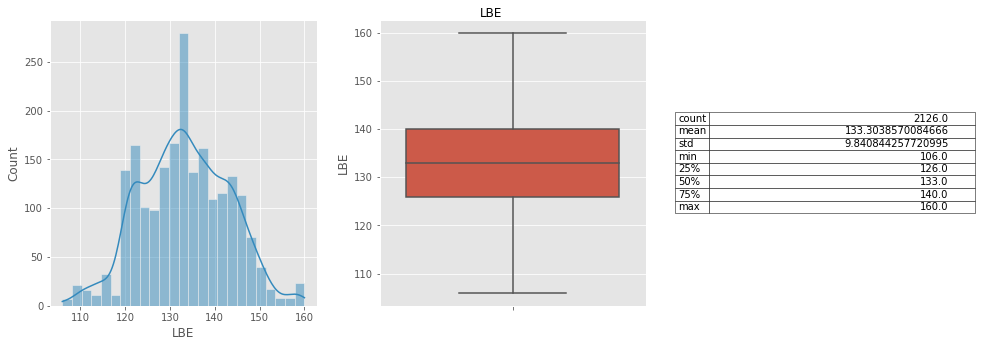

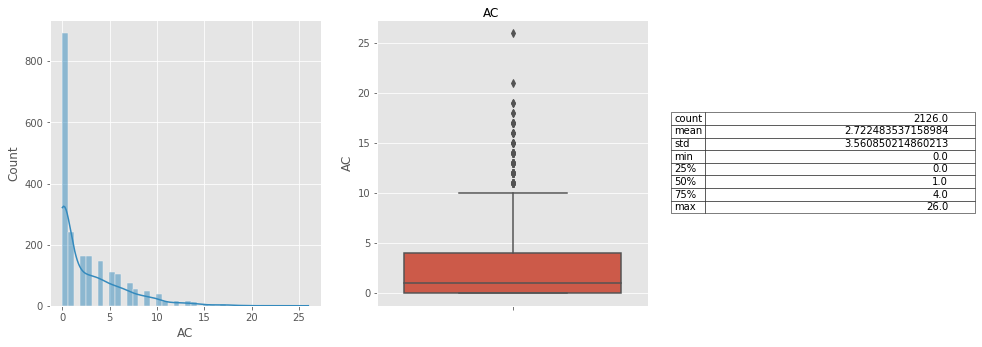

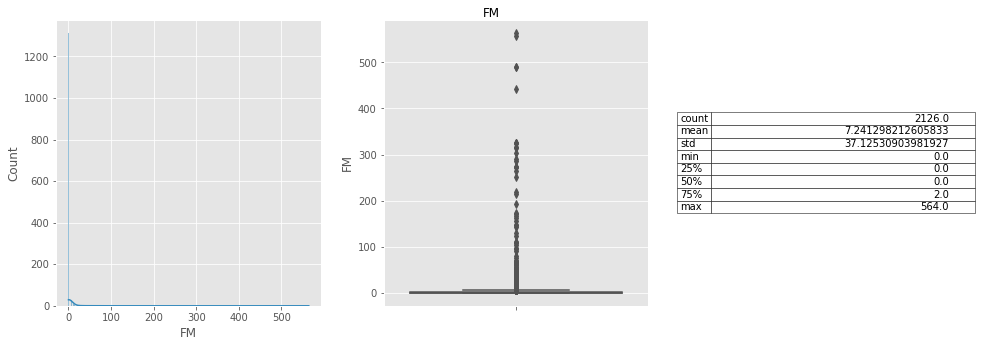

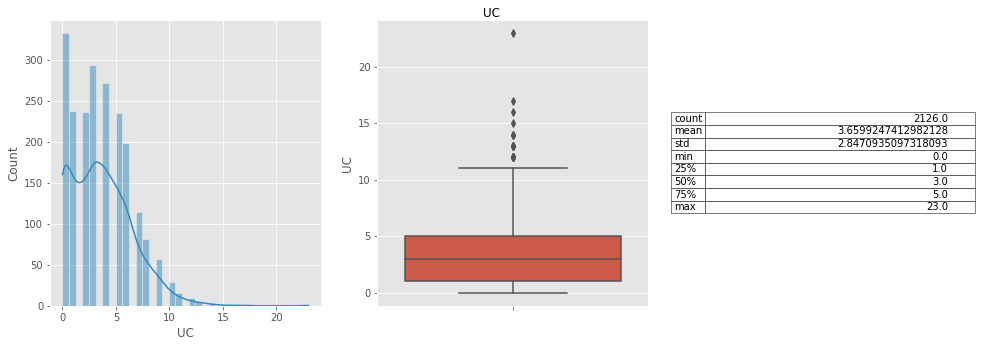

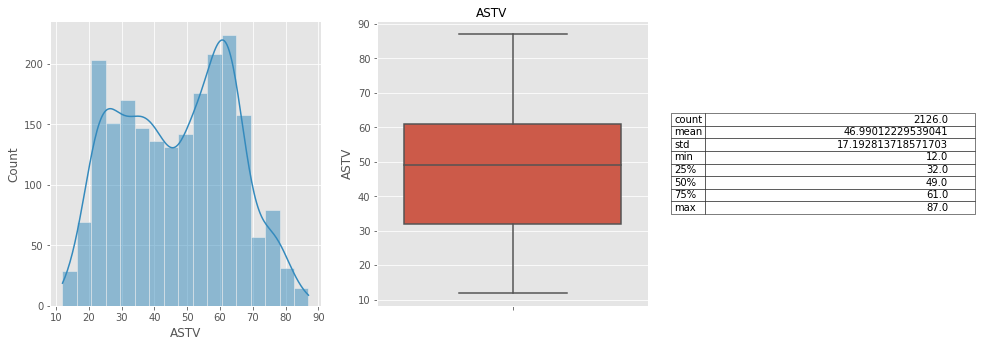

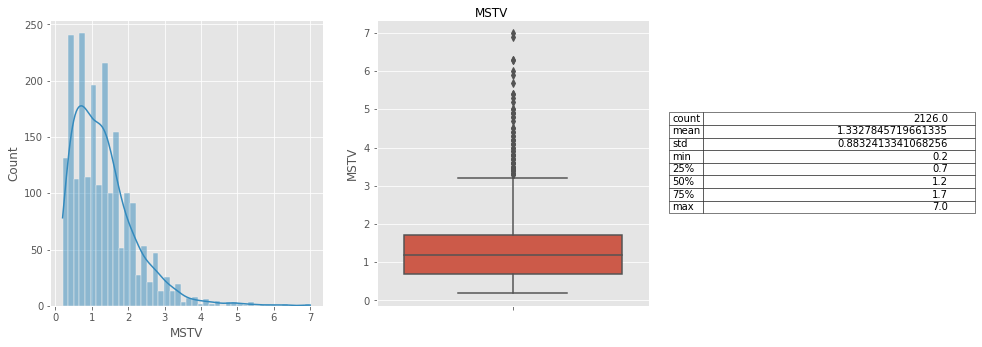

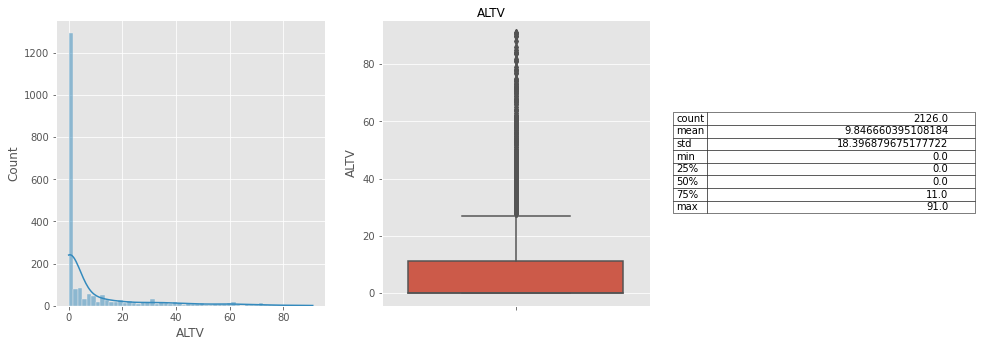

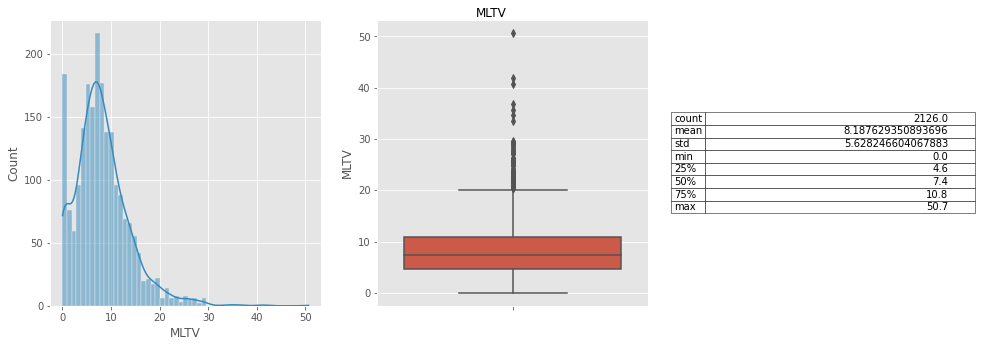

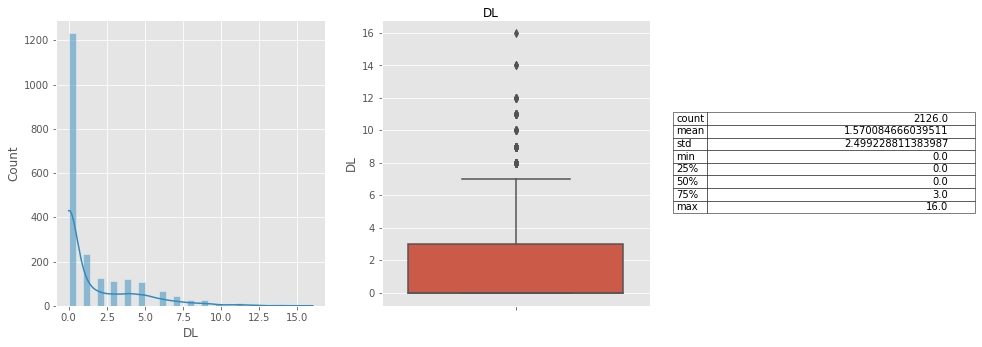

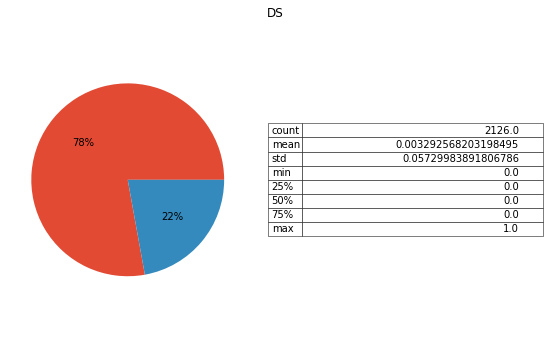

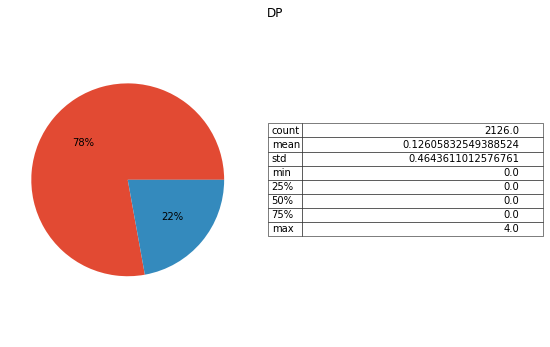

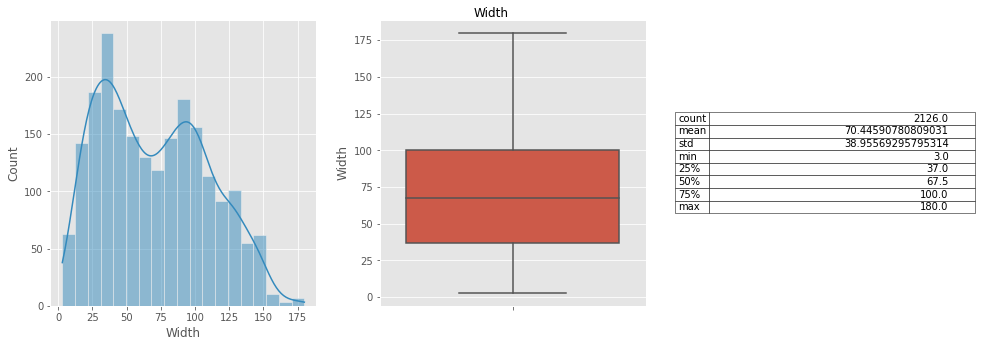

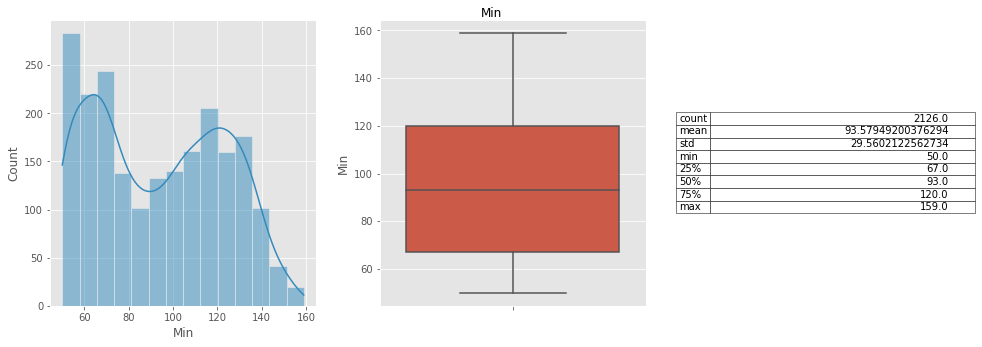

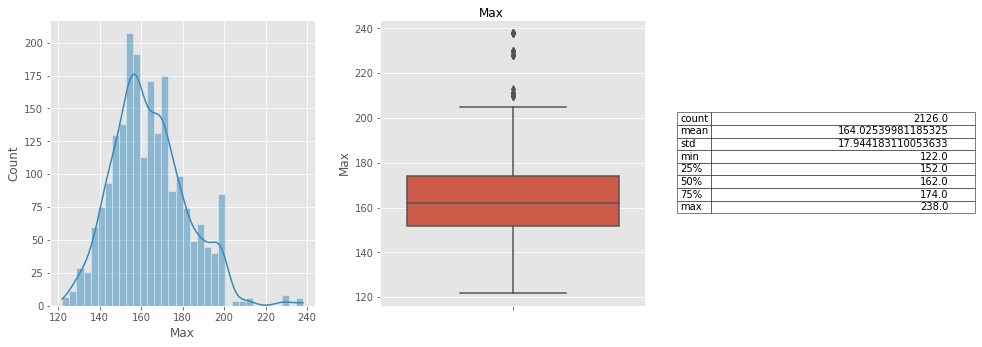

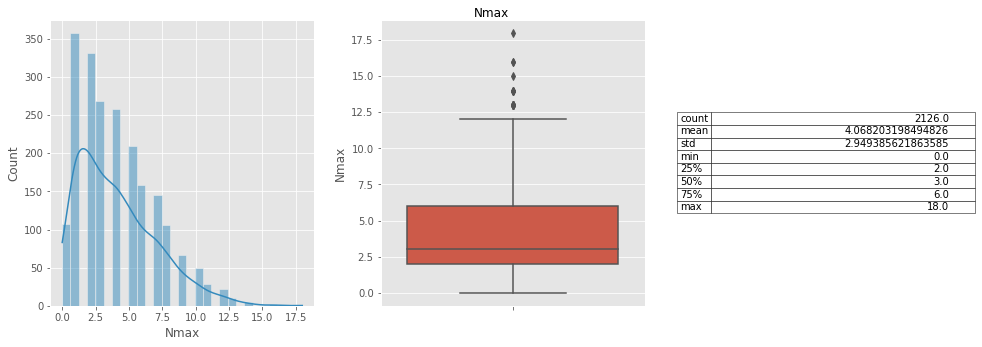

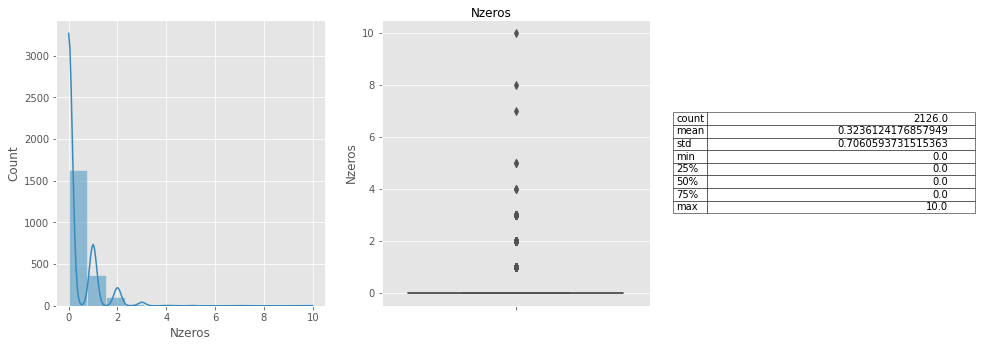

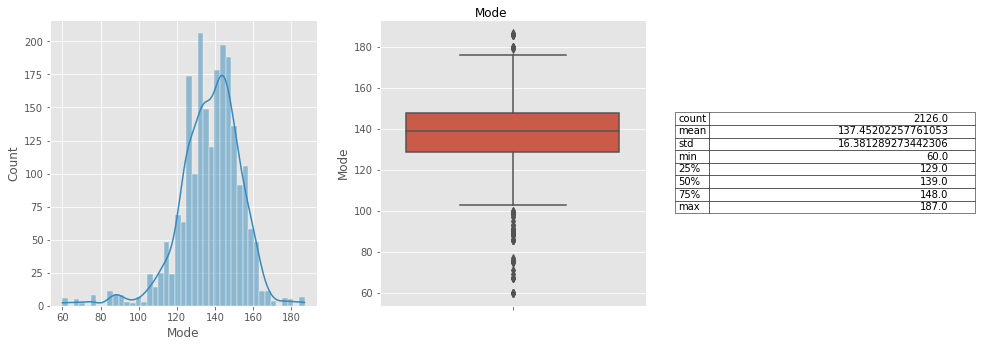

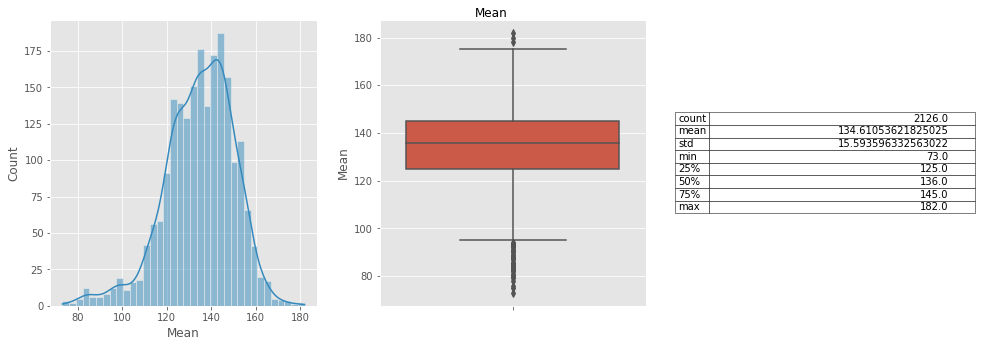

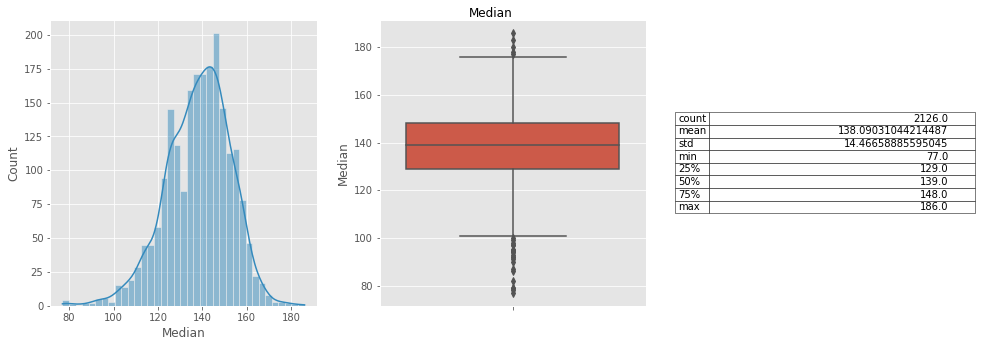

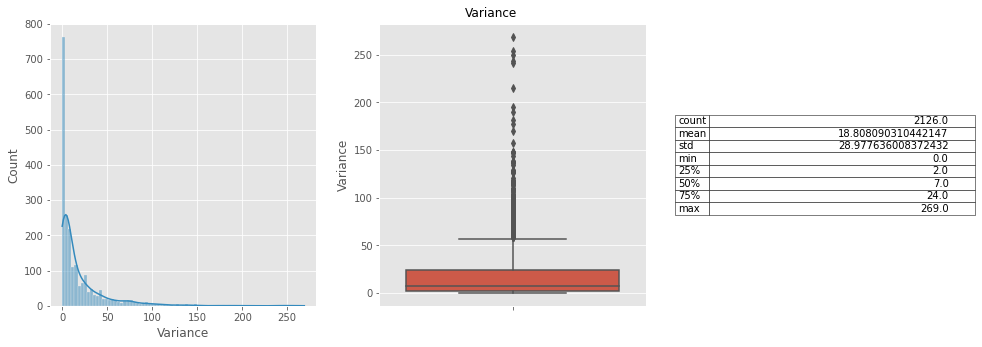

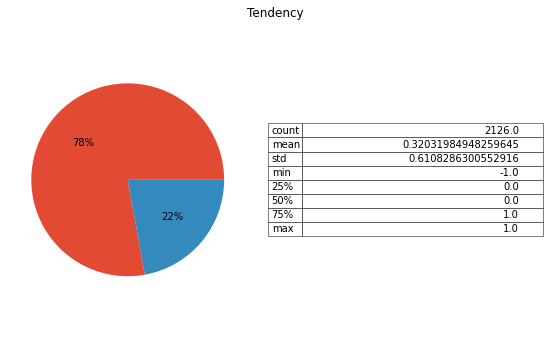

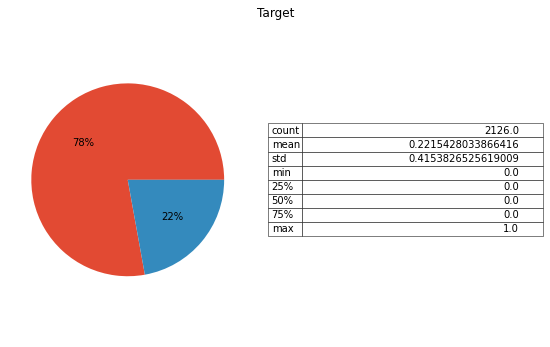

In [12]:
for var in list(data.columns):
  if var in CONTINUOUS_VARS:
    # Mostramos histograma y gráfico de caja
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
    # Las medidas de centralización y posición irán en el tercer gráfico
    tblax = axes[2]
    plt.suptitle(var)
    sns.histplot(data = data, x=var, kde=True, ax=axes[0])
    sns.boxplot(data=data, y=var, ax=axes[1])
  else:
    # Variables discretas
    # Mostramos un gráfico de tarta
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
    # Las medidas de centralización y posición irán en el tercer gráfico
    tblax = axes[1]
    plt.suptitle(var)
    a, b = data['Target'].value_counts()
    axes[0].pie([a, b], autopct="%1.0f%%")

  table = data[var].describe()
  tblax.table(list(zip(table.values)), loc="center", rowLabels=table.index)
  tblax.axis('off')
  plt.tight_layout(pad=2)

### Análisis de correlaciones

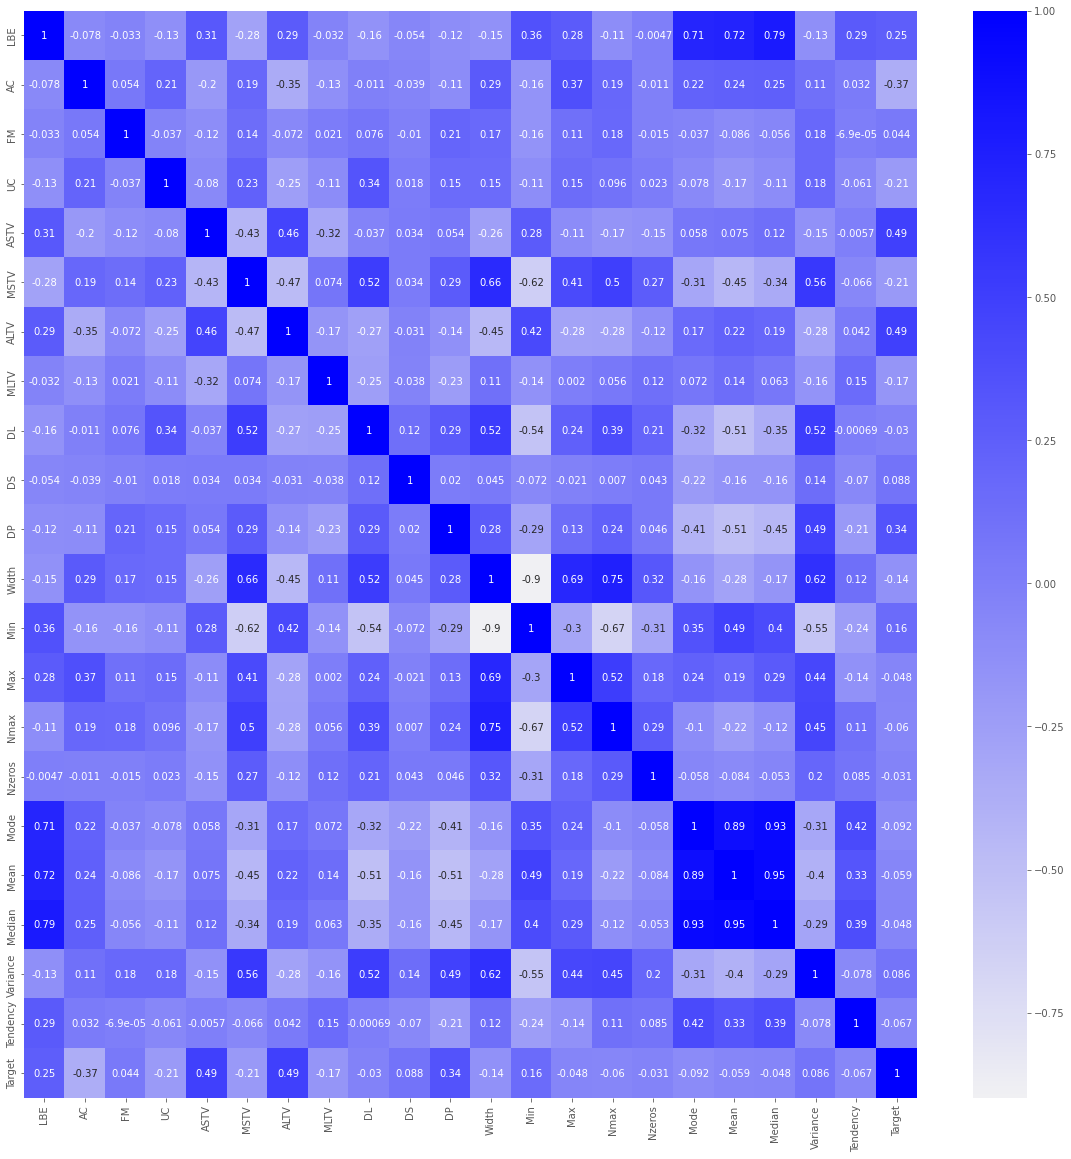

In [13]:
plt.figure(figsize=(20,20))
corr = data.corr()
cmap = sns.color_palette("light:b", as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)
plt.show()

### Relación univariante con la variable objetivo

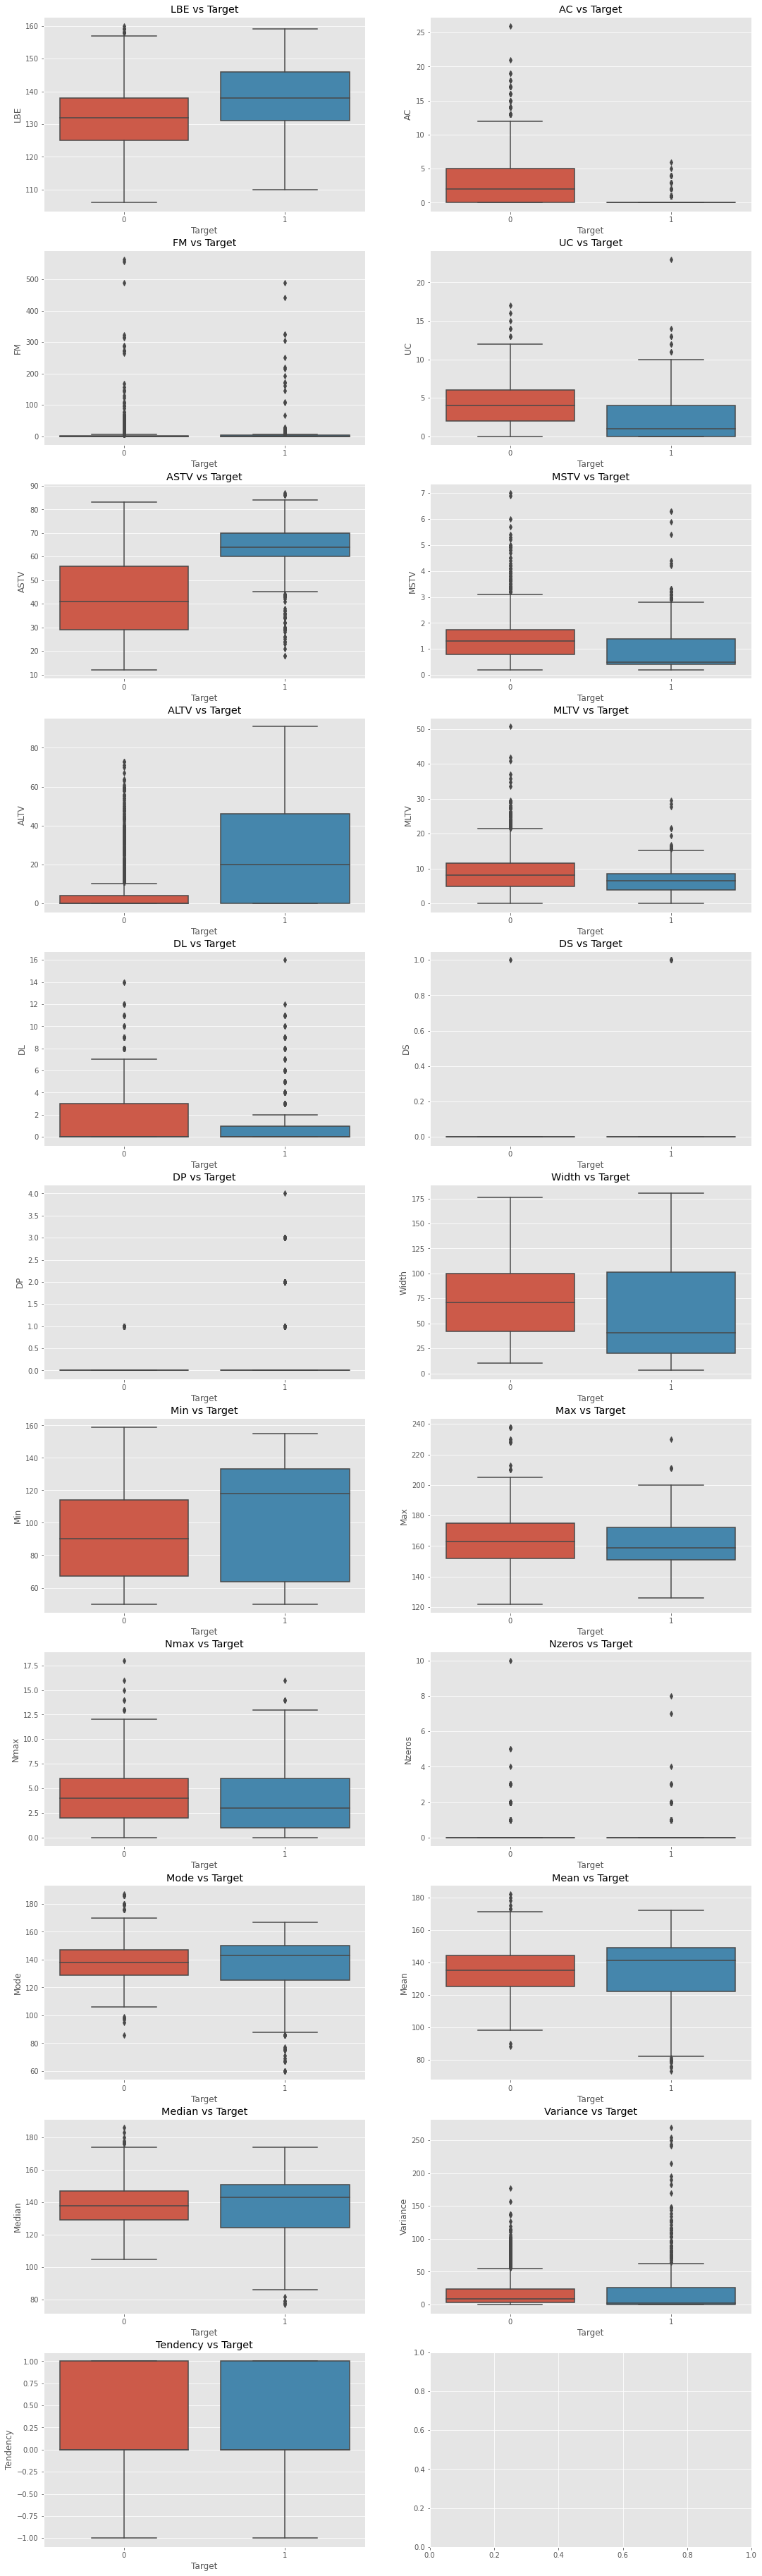

In [14]:
variables = list(data.columns[data.columns != "Target"])
ncols = 2
nrows = int(np.ceil(len(variables)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9*ncols, 6*nrows))

for i, var in enumerate(variables):
  ax = axes[int(np.floor(i/ncols))][i%ncols]
  sns.boxplot(x = 'Target', y= var, data = data, ax=ax)
  ax.set_title(f"{var} vs Target")

## Entrenamiento de Naive Bayes

Antes de entrenar este modelo he probado distintas formas de procesar los datos.

- [Sin procesar los datos](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/2.1-NaiveBayes-default.ipynb)
- [Quitar variables correlacionadas entre sí](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/2.2-NaiveBayes-quitar-correlaciones.ipynb)
- [Quitar variables correlacionadas y tratar los outliers](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/2.3-NaiveBayes-quitar-correlaciones-tratamiento-outliers.ipynb)
- [Quitar variables correlacionadas, tratar los outliers, y aplicar algunas transformaciones](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/2.4-NaiveBayes-quitar-correlaciones-tratamiento-outliers-transformaciones.ipynb)

La mejor prueba ha sido la última. 

También se ha experimentado con distintos métodos de escalado pero el resultado no variaba. Eso es debido al algoritmo empleado dentro de la familia Naive Bayes: [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Ya que este algoritmo ya aplica internamente un estalado de los datos para aproximarlos lo máximo posibe a una distribución normal.

Naive Bayes ha resultado ser un algoritmo muy sensible a la semilla usada, de modo que también he ejecutado un proceso de fuerza bruta para encontrar la que da un mejor modelo, buscando el equilibrio entre una AUC elevada y poco sobreajuste.

In [15]:
# COPIA DE SEGURIDAD DEL DATAFRAME

# Antes de aplicar transformaciones nos guardaemos una copia de los datos
#  para poder recuperar los originales, ya que las tranformaciones
#  son diferentes para cada algoritmo

data_original = data.copy()

In [16]:
# BORRAR VARIABLES CORRELACIONADAS
data.drop(["Max", "Width", "Nmax"], axis=1, inplace=True)


In [17]:
# TRATAMIENTO DE OUTLIERS

def get_limits(variable):
  q1 = variable.quantile(0.25)
  q3 = variable.quantile(0.75)
  iqr = q3 - q1
  return (q1 - 1.5 * iqr), (q3 + 1.5 * iqr)

def get_quartiles(variable):
  quantiles = [0.25, 0.5, 0.75]
  values = []
  for q in quantiles:
    values.append(variable.quantile(q))
  return tuple(values)

## MSTV
name = "MSTV"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por mediana
med = data[name].median()
data[name] = data[name].apply(lambda x: x if x <= top else med)

## AC
name = "AC"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por mediana
med = data[name].median()
data[name] = data[name].apply(lambda x: x if x <= top else med)

## FM
name = "FM"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por 0 o 1
data[name] = data[name].apply(lambda x: 1 if x >= 2 else 0)

## ALTV
name = "ALTV"
_, top = get_limits(data[name])
print(name, top, get_quartiles(data[name]))
# sustituir por 0 o 1
data[name] = data[name].apply(lambda x: 1 if x >= 11 else 0)

MSTV 3.2 (0.7, 1.2, 1.7)
AC 10.0 (0.0, 1.0, 4.0)
FM 5.0 (0.0, 0.0, 2.0)
ALTV 27.5 (0.0, 0.0, 11.0)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8645092130>,
      dtype=object)

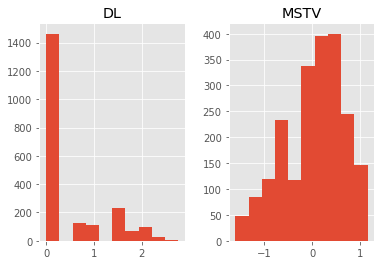

In [18]:
# TRANFORMACIÓN DE VARIABLES

# Transformación logarítmica
vars = ["DL", "MSTV"]
for v in vars:
  data[v] = data[v].apply(lambda x: np.log(x) if x > 0 else x)

data[vars].hist()

In [19]:
# # ENCONTRAR UNA BUENA SEMILLA

# X = data.loc[:, data.columns != "Target"]
# y = data.loc[:, data.columns == "Target"]

# # Fuerza bruta
# # Calculamos el AUC para semillas entre [0, 500) y test_size entre [0.3, 0.9)
# from sklearn.metrics import roc_auc_score
# from tqdm.auto import tqdm

# scores = []
# gnb = GaussianNB()

# for seed in tqdm(range(0, 500)):
#   for i in range(4,5):
#     ts = i / 10
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts , random_state = seed)

#     modelNB = gnb.fit(X_train, y_train.values.ravel())
#     y_pred_train = modelNB.predict_proba(X_train) 
#     y_pred_test = modelNB.predict_proba(X_test)

#     auc_train = roc_auc_score(y_train.values.ravel(), y_pred_train[:,1])
#     auc_test = roc_auc_score(y_test.values.ravel(), y_pred_test[:,1])

#     scores.append((ts, seed, auc_train, auc_test))

# # Buscar la mejor combinación de test-size y seed con estos dos objetivos en mente
# # - Minimiza el sobre-ajuste
# # - Maximizar el área bajo la curva con los datos de entrenamiento

# df_scores = pd.DataFrame(data=scores, columns=["test_size", "seed", "auc_train", "auc_test"])

# # Me invento una métrica llamada "performance"
# # - performance = auc_test * (1 - abs(auc_train - auc_test))

# # Esta métrica funciona del siguiente modo
# # - cuanto mayor es auc_test mejor es performance
# # - cuanto mayor es el sobreajuste (auc_train - auc_test) peor es performance

# # Calculamos la métrica
# df_scores["performance"] = df_scores.auc_test * (1 - (np.abs(df_scores.auc_train - df_scores.auc_test)*0.9))

# # Estimamos el sobreajuste para cada test_size y semila

# df_scores["overfit_est"] = np.abs(df_scores.auc_train - df_scores.auc_test)

# # # Obtenemos la mejor combinación
# aux = df_scores.nlargest(3, "performance").reset_index()
# best_ts = aux.loc[0,"test_size"]
# best_seed = aux.loc[0,"seed"]
# print(f"test_size={best_ts}; seed={best_seed}")
# aux

# Esta es la mejor combinación de test-size y semilla
#  usaré este valor para el muestreo tanto de NB como de SVM
best_ts = 0.4
best_seed = 124

In [20]:
# MUESTREO
X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = best_ts, random_state = best_seed)

In [21]:
# ENTRENAMIENTO NAIVE BAYES
gnb = GaussianNB()

modelNB = gnb.fit(X_train, y_train.values.ravel())
y_pred_train_nb = modelNB.predict_proba(X_train) 
y_pred_test_nb = modelNB.predict_proba(X_test)

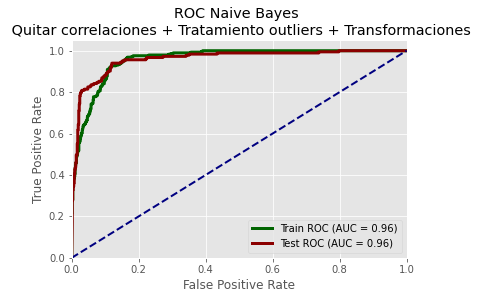

In [22]:
# VALIDACIÓN
#
# Encapsulamos la generación de la curva ROC en una función reutilizable
#
def plot_ROC(y_train, y_test, pred_train, pred_test, title="ROC"):
  # CURVA ROC Y AUC PARA TRAINING
  fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
  roc_auc_train = auc(fpr_train, tpr_train)

  # CURVA ROC Y AUC PARA TEST
  fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
  roc_auc_test = auc(fpr_test, tpr_test)

  # GRAFICA
  plt.figure()
    
  lw = 2

  plt.plot(fpr_train,tpr_train,color="darkgreen",lw=lw+1,label="Train ROC (AUC = %0.2f)" % roc_auc_train,)
  plt.plot(fpr_test,tpr_test,color="darkred",lw=lw+1,label="Test ROC (AUC = %0.2f)" % roc_auc_test,)

  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

plot_ROC(
    y_train=y_train,
    y_test=y_test,
    pred_train=y_pred_train_nb,
    pred_test=y_pred_test_nb,
    title="ROC Naive Bayes \n Quitar correlaciones + Tratamiento outliers + Transformaciones"
)
   

## Entrenamiento de Support Vector Machine

Antes de entrenar este modelo he probado distintas formas de procesar los datos.

- [Sin procesar](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/3.1-SVM-default.ipynb)
- [Quitar variables correlacionadas entre sí](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/3.2-SVM-quitar-correlaciones.ipynb)
- [Tratar outliers](https://github.com/tuxsy/iebs-master-data-science/blob/main/m04/proyecto/Pruebas/3.3-SVM-tratamiento-outliers.ipynb)

En este caso la mejor prueba ha sido la segunda, es decir: sólo ha bastado eliminar las variables altamente correlacionadas para conseguir un buen modelo.

También he experimentado con otras opciones, igual que con Naive Bayes, pero el modelo empeoraba un poco cada vez: menor AUC y mayor sobreajuste.

In [23]:
# RECUPERAMOS LOS DATOS ORIGINALES

# No nos intersa mantener el proccesado hecho para Naive Bayes
#  por lo tanto vamos a volver a procesar los datos y a muestrear
data = data_original

In [24]:
# BORRAR VARIABLES CORRELACIONADAS

# Cluster ["Mode", "Mean", Median]
data.drop(["Mode", "Median"], axis=1, inplace=True)

# Cluster ["Max", "Min", "Nmax", "Width"]
data.drop(["Max", "Min", "Nmax"], axis=1, inplace=True) 

# MAYORÍA DE VALORES CERO
data.drop(["Nzeros"], axis=1, inplace=True) # Reduce un poco el sobreauste

In [25]:
# MUESTREO
X = data.loc[:, data.columns != "Target"]
y = data.loc[:, data.columns == "Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = best_ts, random_state = best_seed)

In [26]:
# SELECCIÓN DE HIPERPARÁMETROS
# Creamos un Grid para probar estos Hiperparámetros
param_grid = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [0.1,1,10]},
    {"kernel": ["linear"], "C": [0.1,1,10]},
    {"kernel": ["poly"], "C": [0.1,1,10], "degree": [2,3]},
]

# Creamos la regilla
grid = GridSearchCV(
        estimator  = SVC(),
        param_grid = param_grid, 
        scoring    = 'accuracy', # roc_auc, accuracy
        n_jobs     = -1,
        cv         = 3, 
        verbose    = 0,
        return_train_score = True
      )

# Ajustamos
grid.fit(X = X_train, y = y_train)

# Mostramos los mejoes hiperparámetros según GidSearch

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.001)


In [27]:
# ENTRENAMIENTO SVM
svm = SVC(
    **grid.best_params_, # Hiperparámetros calculados por GridSearch
    probability=True     # Lo necesitamos para calcular la curva ROC
  )

svm.fit(X_train, y_train)

print(svm)

y_pred_train_svm = svm.predict_proba(X_train)
y_pred_test_svm = svm.predict_proba(X_test)

SVC(C=10, gamma=0.001, probability=True)


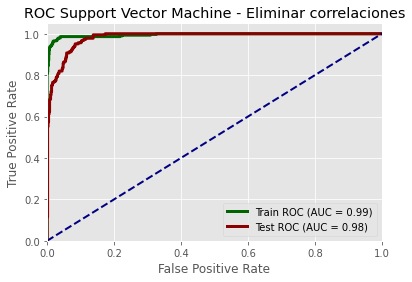

In [28]:
# VALIDACIÓN

plot_ROC(
    y_train=y_train,
    y_test=y_test,
    pred_train=y_pred_train_svm,
    pred_test=y_pred_test_svm,
    title="ROC Support Vector Machine - Eliminar correlaciones"
)

## Comparativa entre los modelos

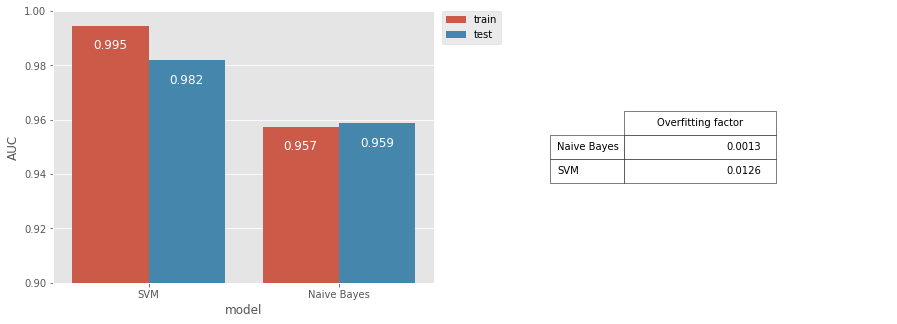

In [29]:
# Comparación de curvas

# AUC para SVM
auc_train_svm = roc_auc_score(y_train.values.ravel(), y_pred_train_svm[:,1])
auc_test_svm = roc_auc_score(y_test.values.ravel(), y_pred_test_svm[:,1])

# AUC para NB
auc_train_nb = roc_auc_score(y_train.values.ravel(), y_pred_train_nb[:,1])
auc_test_nb = roc_auc_score(y_test.values.ravel(), y_pred_test_nb[:,1])


# Creamos un data frame con las métrics
df_metrics = pd.DataFrame(
    data=[
        ("SVM", auc_train_svm, "train"),
        ("SVM", auc_test_svm, "test"),
        ("Naive Bayes", auc_train_nb, "train"),
        ("Naive Bayes", auc_test_nb, "test")
    ],
    columns=["model", "AUC", "dataset"]
)

# Creamos el gráfico de barras
# fig, ax = plt.subplots(figsize=(8, 6))
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(121)
bar = sns.barplot(data=df_metrics, x="model", y="AUC", hue="dataset", ax=ax)
plt.ylim(0.9, 1)

# Insertamos el valor del AUC en el gráifco
for p in ax.patches:
    h, w, x = p.get_height(), p.get_width(), p.get_x()
    xy = (x + w / 2., h / 2)
    text = f'Mean:\n{h:0.2f}'
    # ax.annotate(text=text, xy=xy, ha='center', va='center')
    ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'center', 
                   size=12,xytext = (0, -20), 
                   textcoords = 'offset points', color="white")

# Ajustamos la posición de la leyenca
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Añadimos una tabla resumen
table_data = df_metrics.groupby("model").agg(["max", "min"])["AUC"]
table_data["overfit_factor"] = table_data["max"] - table_data["min"]
ax = plt.subplot(122)
cell_text = ['%1.4f' % x for x in table_data.overfit_factor]
tbl = ax.table(cellText=list(zip(cell_text)), loc="center",
      rowLabels=table_data.index, colLabels=["Overfitting factor"])
tbl.scale(0.4, 2)
ax.axis("off")

plt.show()

## Determinar el mejor umbral para la predicción

Al realizar las predicciones tenemos una probabilidad, ¿a partir de qué probabilidd debemos considerar que el valor es positivo?

Para ello vamos a analizar las probabilidades al ejecutar el modelo con todos los datos

In [30]:
# Obtenemos las probabilidades para todos los datos
predicciones = svm.predict_proba(X)

# Nos quedamos con las probabilidades de la clase 1
predicciones = predicciones[:,1]



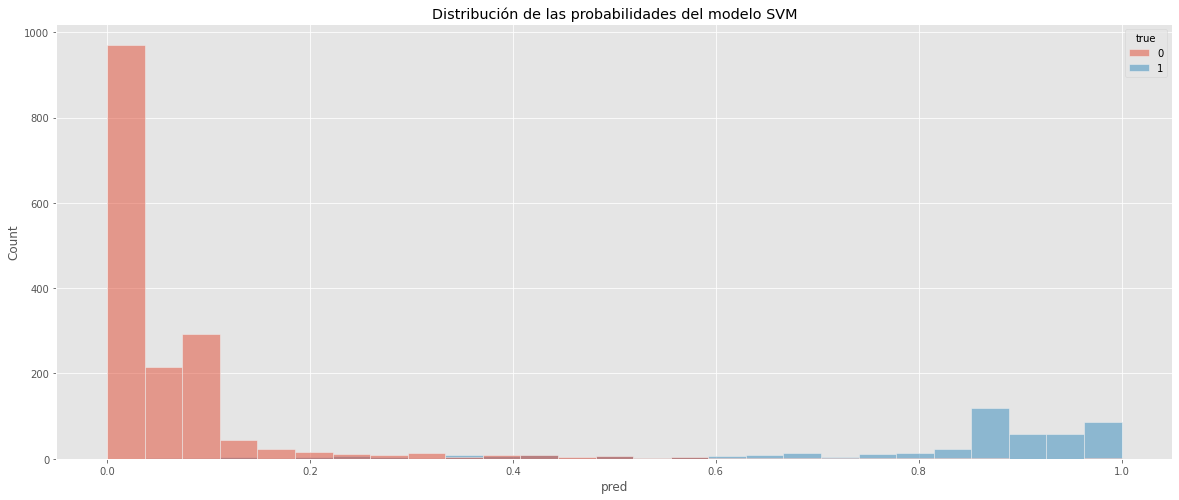

In [128]:
# Mostramos un histograma para ver cómo están de repartidas las probabilidades
df = pd.DataFrame({
    "pred": predicciones,
    "true": y.values.ravel()
})
plt.figure(figsize=(20,8))
sns.histplot(df, x="pred", hue="true")
plt.title("Distribución de las probabilidades del modelo SVM")
plt.show()

Este diagrama muestra las probabilidades predichas por el modelo SVM coloreadas según la clase real de los datos:

- 0 bebé sano
- 1 anomalía detectada

Aunque es sutil, vemos que en algunos casos el modelo ha predecido una probabilidad baja (< 40%) y en cambio la clase real es positiva.

In [129]:
# ¿Cuál es la probabilidad mínimia predecida por el modelo para la clase positiva?

df.loc[df.true == 1, "pred"].min()

0.06125790150320445

Vemos que hay al menos un caso en el que el modelo ha calculado una probabilidad de que el feto presente alguna anomalía realmente baja (6%) y en cambio el feto sí preseentaba una anomalía real.

Vamos a analizar algunos cuantiles para entender mejor cómo se distribuyen las probabilidades

In [130]:
# Análisis de cuantiles para la clase 1

for q in [0.01,0.02, 0.03, 0.04, 0.05, 0.1, 0.2]:
  print(f"{q*100}% \t <= {df.loc[df.true == 1, 'pred'].quantile(q):1.3f}")

1.0% 	 <= 0.135
2.0% 	 <= 0.164
3.0% 	 <= 0.216
4.0% 	 <= 0.248
5.0% 	 <= 0.280
10.0% 	 <= 0.430
20.0% 	 <= 0.696


Según est análisis, si eligiéramos un umbral del 40% diagnosticaríamos como sanos a un 10% de bebés con anomalías.

Si queremos reducir el margen de error:

- al 3% el umbral debería ser 0.2
- al 2% el umbral debería ser 0.16
- al 1% el umbral debería ser 0.14

Considero que es preferible clasificar un feto con anomalías y que sea normal, y proceder a hacer más pruebas; que al revés y confiarnos. 

Por lo tanto no considero adecuado el umbral por defecto del modelo SVM que es 0.5 y eligiría un umbral ás bajo, como 0.135 o 0.164 como máximo.

## Conclusiones

Los dos modelos podrían emplearse como apoyo al diagnóstico de un equipo médico.

Recomendaría desplegar estos modelos el **modo experimental** y como apoyo (como he dicho antes) ya que es necesario realizar pruebas y entrenar con más datos antes de confiar al 100%.

La métrica usada ha sido el *área bajo la curva* (AUC). Aunque el algoritmo SVM ha sido superior en términos de AUC, éste presenta más sobreajuste que Naive Bayes.

Además hemos visto que, aunque el modelo SVM tiene un buen ajuste, podemos tener muchos falsos negativos si usamos el umbral por defecto parfa la probabilidad, por lo cual deberíamos ajustarlo muy a la baja.

Ante esta situación mi recomendación sería realizar las predicciones con ambos modelos (en la fase experimental que comentaba antes) y estudiar:

- Cuantas veces conicide la predicción en ambos modelos
  - Cuantas veces la predicción es acertada
  - Cuantas veces la predicción es incorrecta
- Cuantas veces la predicción es diferente
  - Cuantas veces la predicción acertada es la de NB
  - Cuanatas veces la predicción acertada es la de SVM
  - Cuantas veces no hemos acertado en la predicción
